In [9]:
import numpy as np
import scipy.sparse as spsp
import networkx as nx
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
import time
import scipy.io
import random
from operator import itemgetter
%matplotlib inline

In [10]:
def lu_iter_(L, U, i, j, n, m):
    for k in range(j, j + m):
        a = U[k, k]
        for row in range(max(i, k + 1), i + n):
            b = U[row, k]
            if abs(b) > 1e-6:
                L.append((row, k, b / a))
                U[row] -= b * (U[k] / a)


def rec_partitioning_(P, L, U, i, n, fseparate):
    if n < 20: return  # extreme case

    P_local, a, b, g = fseparate(U[i:(i+n), i:(i+n)])  # gets permutation for block-arrow shape
    P_i = np.arange(0, U.shape[0], dtype=np.int32)  # perm in i-th iteration
    P_i[i:(i + n)] = P_local + i
    U[:] = U[P_i, :][:, P_i]  # apply permutation to U (inplace)
    P[:] = P[P_i]

    if max(a, b, g) < n:
        rec_partitioning_(P, L, U, i + a + b, g, fseparate)  # (gamma, gamma)
        rec_partitioning_(P, L, U, i, a, fseparate)  # (alpha, alpha)
        rec_partitioning_(P, L, U, i + a, b, fseparate)  # (beta, beta)


def rec_partitioning(A, fseparate, copy=True):
    P = np.arange(0, A.shape[0], dtype=np.int32)  # default perm
    L = [(i, i, 1) for i in range(0, A.shape[0])]  # fills diagonal by 1
    U = A.tolil(copy=copy)

    # P, L, U changes inplace
    rec_partitioning_(P, L, U, 0, A.shape[0], fseparate)
    P = np.argsort(P)  # applies transpose
    lu_iter_(L, U, 0, 0, A.shape[0], A.shape[0])

    # create sparse matrix from coo list
    row = [L[i][0] for i in range(len(L))]
    col = [L[i][1] for i in range(len(L))]
    data = [L[i][2] for i in range(len(L))]
    L = spsp.csr_matrix((data, (row, col)), dtype=A.dtype)

    return P, L, U

In [11]:
def get_separate_perm(mat):
    # finds Fiedler vector
    G = nx.Graph(mat)
    mat = nx.adjacency_matrix(G, weight=None)
    G = nx.Graph(mat)
    Laplacian = nx.laplacian_matrix(G).asfptype().tocoo()  # fix excessive copying!

    eigval, eigvec = spsp.linalg.eigsh(Laplacian, k=2, which="SM")
    colors = np.sign(eigvec[:, 1])

    # gets 3 sets, where gamma - separator
    if eigval[1] < 1e-5:  # checks on not connected graph
        alpha = spsp.csgraph.depth_first_order(Laplacian, 0, return_predecessors=False)
        beta = np.setdiff1d(np.arange(0, len(colors), dtype=np.int32), alpha)
        gamma = np.array([], dtype=np.int32)
    else:
        gamma = set()
        for k in range(0, len(Laplacian.row)):
            i = Laplacian.row[k]
            j = Laplacian.col[k]
            if j > i and colors[i] != colors[j]:
                gamma.add(i)
                gamma.add(j)
        gamma = np.array(list(gamma), dtype=np.int32)
        beta = np.setdiff1d(np.where(colors > 0), gamma)
        alpha = np.setdiff1d(np.where(colors < 0), gamma)

    # creates permutation based on sets
    a, b, g = len(alpha), len(beta), len(gamma)
    P = np.concatenate((alpha, beta, gamma), dtype=np.int32)
    return P, a, b, g

C:\Users\Jukvo\AppData\Local\Temp\ipykernel_12396\870128185.py:6: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.13.0.
  Laplacian = nx.laplacian_matrix(G).asfptype().tocoo()  # fix excessive copying!


time decomposition [s] =  26.984519004821777
norm(A) =  153.88307249337075
norm(LU) =  153.88307249337075
norm(P(LU)P - A) =  2.620626992331624e-14


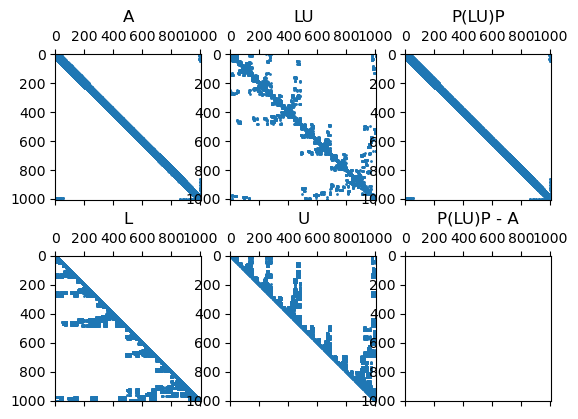

In [5]:
import time
import scipy.io
import networkx as nx
import scipy.sparse as spsp
import matplotlib.pyplot as plt

datasets = ["arc130.mtx", "494_bus.mtx", "dwt_1007.mtx"]
path_to_dataset = "./datasets/" + datasets[2]
dtype = np.float32

# read data (graph)
A = spsp.csr_matrix(scipy.io.mmread(path_to_dataset), dtype=dtype)
A = A + 3 * spsp.eye(A.shape[0])

# gets decomposition
start = time.time()
P, L, U = rec_partitioning(A, get_separate_perm)
end = time.time()
print("time decomposition [s] = ", end - start)

# checks accuracy
LU = L.dot(U)
PLUP = LU[P, :][:, P]
print("norm(A) = ", spsp.linalg.norm(A, ord='fro'))
print("norm(LU) = ", spsp.linalg.norm(LU, ord='fro'))
print("norm(P(LU)P - A) = ", spsp.linalg.norm(PLUP - A, ord='fro'))

# shows plot (report)
data = [A, LU, PLUP, L, U, PLUP - A]
labels = ["A", "LU", "P(LU)P", "L", "U", "P(LU)P - A"]
fig, axs = plt.subplots(2, len(data) // 2)
for i in range(2):
    for j in range(len(data) // 2):
        axs[i, j].spy(data[i * 3 + j], aspect='equal', marker='.', markersize=2, precision=1e-5)
        axs[i, j].set_title(labels[i * 3 + j])

time decomposition [s] =  49.51230764389038
norm(A) =  153.88307249337075
norm(LU) =  153.88307249337075
norm(P(LU)P - A) =  3.4951593252083717e-14


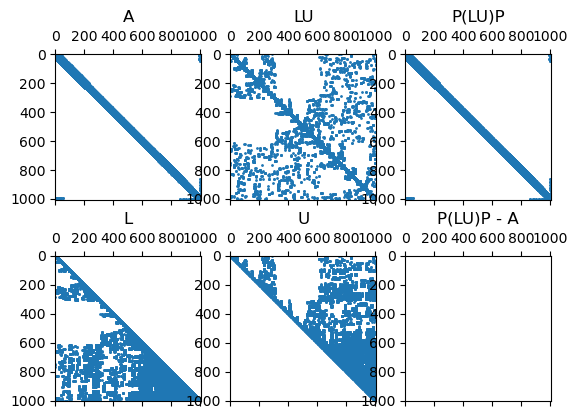

In [12]:
def kernighan_lin(sparse_matrix):
    G = nx.Graph(sparse_matrix)
    mat = nx.adjacency_matrix(G, weight=None)
    G = nx.Graph(mat)

    partition_a, partition_b = nx.community.kernighan_lin_bisection(G, max_iter=1000, seed=911)

    separator = set()
    connecting_edges = []

    for edge in G.edges():
        if (edge[0] in partition_a and edge[1] in partition_b) or (edge[0] in partition_b and edge[1] in partition_a):
            connecting_edges.append(edge)

    for edge in connecting_edges:
        if (edge[0] not in separator) and (edge[1] not in separator):
            separator.add(edge[0])
            separator.add(edge[1])

    partition_a -= separator
    partition_b -= separator

    partition_a = np.array(list(partition_a))
    partition_b = np.array(list(partition_b))
    separator = np.array(list(separator))

    a, b, g = len(partition_a), len(partition_b), len(separator)
    start = 0
    P = np.zeros(G.number_of_nodes(), dtype=np.int32)
    if a > 0: P[partition_a] = np.arange(start, start + a)
    start += a
    if b > 0: P[partition_b] = np.arange(start, start + b)
    start += b
    if g > 0: P[separator] = np.arange(start, start + g)
    P = P.argsort()
    return P, a, b, g


# gets decomposition
start = time.time()
P, L, U = rec_partitioning(A, kernighan_lin)
end = time.time()
print("time decomposition [s] = ", end - start)

# checks accuracy
LU = L.dot(U)
PLUP = LU[P, :][:, P]
print("norm(A) = ", spsp.linalg.norm(A, ord='fro'))
print("norm(LU) = ", spsp.linalg.norm(LU, ord='fro'))
print("norm(P(LU)P - A) = ", spsp.linalg.norm(PLUP - A, ord='fro'))

# shows plot (report)
data = [A, LU, PLUP, L, U, PLUP - A]
labels = ["A", "LU", "P(LU)P", "L", "U", "P(LU)P - A"]
fig, axs = plt.subplots(2, len(data) // 2)
for i in range(2):
    for j in range(len(data) // 2):
        axs[i, j].spy(data[i * 3 + j], aspect='equal', marker='.', markersize=2, precision=1e-5)
        axs[i, j].set_title(labels[i * 3 + j])

(1007, 1007)
Graph with 1007 nodes and 4791 edges


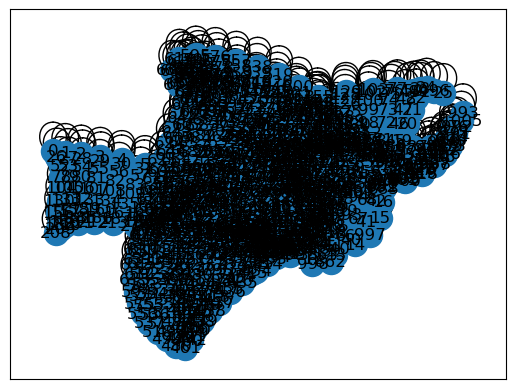

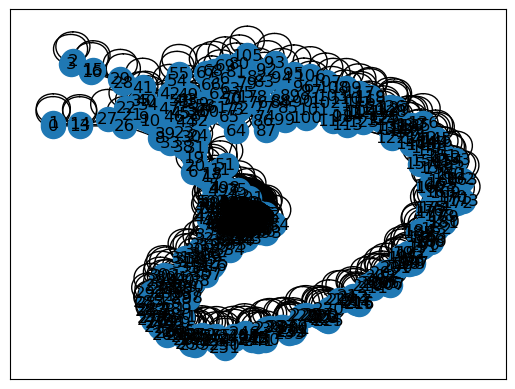

Graph with 508 nodes and 5342 edges


In [13]:
def maximal_matching(graph):
    matching = set()
    unmatched_nodes = set(graph.nodes)
    #print(unmatched_nodes)
    for node in graph.nodes:
        if node in unmatched_nodes:
            for neighbor in graph.neighbors(node):
                if neighbor is not None and neighbor in unmatched_nodes and neighbor!=node:
                    a = max(node, neighbor)
                    b = min(node, neighbor)
                    matching.add((a, b))
                    #print('NODE', node)
                    #print('NEIGHBOR', neighbor)
                    unmatched_nodes.remove(node)
                    unmatched_nodes.remove(neighbor)
                    break

    #return list(matching)
    return matching


def coarsening_phase(mat):
    G = nx.Graph(mat)
    #mat = nx.adjacency_matrix(G, weight=None)
    #G = nx.Graph(mat)
    print(mat.shape)
    matching = maximal_matching(G)
    t = sorted(matching, reverse=True, key=itemgetter(0))
    AA = nx.adjacency_matrix(G).todense()
    x = []
    for i in range(mat.shape[0]):
        x.append(i)
    for i in range(len(t)):
        AA[t[i][1]] += AA[t[i][0]]
        AA = np.delete(AA, i, 0)
        AA = np.delete(AA, i, 1)
        x[t[i][1]] = t[i]
        x.remove(int(t[i][0]))

    #G1 = nx.Graph()
    #G1.add_nodes_from(range(mat.shape[0]))
    #G1.add_edges_from(matching)
    #BB = nx.adjacency_matrix(G1)
    #BB = BB.todense()
    return AA,x


# Example Usage
coarsened_matr, m = coarsening_phase(A)
original_graph = nx.Graph(A)
print(original_graph)
nx.draw_networkx(original_graph)
plt.show()
coarsened_graph = nx.Graph(coarsened_matr)
plt.figure()
nx.draw_networkx(coarsened_graph)
plt.show()
print(coarsened_graph)

In [ ]:
M = spsp.csr_matrix(nx.adjacency_matrix(coarsened_graph))
M = M + 3 * spsp.eye(M.shape[0])

start = time.time()
P, L, U = rec_partitioning(M, kernighan_lin)
end = time.time()
print("time decomposition [s] = ", end - start)

# checks accuracy
LU = L.dot(U)
PLUP = LU[P, :][:, P]
print("norm(A) = ", spsp.linalg.norm(A, ord='fro'))
print("norm(LU) = ", spsp.linalg.norm(LU, ord='fro'))
print("norm(P(LU)P - M) = ", spsp.linalg.norm(PLUP - M, ord='fro'))

# shows plot (report)
data = [M, LU, PLUP, L, U, PLUP - M]
labels = ["A", "LU", "P(LU)P", "L", "U", "P(LU)P - M"]
fig, axs = plt.subplots(2, len(data) // 2)
for i in range(2):
    for j in range(len(data) // 2):
        axs[i, j].spy(data[i * 3 + j], aspect='equal', marker='.', markersize=2, precision=1e-5)
        axs[i, j].set_title(labels[i * 3 + j])